# Data Challenge Overview:

For this data science challenge you are provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.
The goal of this data science challenge is twofold:
1. To calculate the potential for yearly reduction on CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxi cab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.
2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

Bonus question:
3. Identify clusters of taxi cabs that you find being relevant from the taxi cab company point of view.

## Import Initial Packages

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
from os import listdir
from os.path import join as jp
import matplotlib.pyplot as plt
import math
import gc
from geopy.distance import geodesic

## Load Initial Data

In [2]:
dir_path = "cabspottingdata/"
list_files = [file_name for file_name in listdir(dir_path) if file_name.endswith('.txt')]
total_files = len(list_files)
print(f'Total files : {total_files}')

Total files : 537


### Define dataframe converter function

In [3]:
def conv_df(filename: str):
    df = pd.read_csv(jp(dir_path, filename), sep=' ', header=None)
    df.index = filename.split('.')[0] + "_" + df.index.map(str)
    df.columns = ['lat', 'long', 'occupancy', 'timestamp']
    df['taxi_name'] = filename.split('.')[0]
    return df

### Process initial data loader

In [7]:
initial_data = pd.DataFrame()
counter=1
for f in list_files:
    print(f'Processing file : {str(f)} ({counter} of {total_files})...', end='\r')
    df = conv_df(filename=f)
    initial_data = pd.concat([initial_data, df])
    counter=counter+1
print('\nInitial Data successfully loaded')

Processing file : new_uvreoipy.txt (537 of 537)...
Initial Data successfully loaded


In [10]:
initial_data.head()

,lat,long,occupancy,timestamp,taxi_name
new_abboip_0,37.75153,-122.39447,0,1211033530,new_abboip
new_abboip_1,37.75149,-122.39447,0,1211033614,new_abboip
new_abboip_2,37.75149,-122.39447,0,1211033674,new_abboip
new_abboip_3,37.75149,-122.39446,0,1211033735,new_abboip
new_abboip_4,37.75144,-122.39449,0,1211035303,new_abboip


### Save/Load initial data

In [2]:
#initial_data.to_pickle('initial_data.parquet',compression='zip')
initial_data=pd.read_pickle('initial_data.parquet',compression='zip')

## Data Pre Processing

### Initial Feature Transformation

#### Add Date Features

In [3]:
def add_date_var(df: pd.DataFrame):
    df['date']=pd.to_datetime(df['timestamp'],unit='s').dt.date
    df['month']=pd.to_datetime(df['timestamp'],unit='s').dt.month
    df['day']=pd.to_datetime(df['timestamp'],unit='s').dt.day
    df['hour']=pd.to_datetime(df['timestamp'],unit='s').dt.hour
    df['minute']=pd.to_datetime(df['timestamp'],unit='s').dt.minute
    df['weekday']=pd.to_datetime(df['timestamp'],unit='s').dt.weekday

    return df

In [4]:
prep_data = initial_data.copy()
prep_data = add_date_var(df=prep_data)

In [5]:
del initial_data
gc.collect()
prep_data.head()

,lat,long,occupancy,timestamp,taxi_name,date,month,day,hour,minute,weekday
new_abboip_0,37.75153,-122.39447,0,1211033530,new_abboip,2008-05-17,5,17,14,12,5
new_abboip_1,37.75149,-122.39447,0,1211033614,new_abboip,2008-05-17,5,17,14,13,5
new_abboip_2,37.75149,-122.39447,0,1211033674,new_abboip,2008-05-17,5,17,14,14,5
new_abboip_3,37.75149,-122.39446,0,1211033735,new_abboip,2008-05-17,5,17,14,15,5
new_abboip_4,37.75144,-122.39449,0,1211035303,new_abboip,2008-05-17,5,17,14,41,5


#### Add Lag Features

In [6]:
def add_lag_var(df: pd.DataFrame):
    df['lat_lag1'] = df.groupby(['taxi_name']).shift(1)['lat']
    df['lat_lag2'] = df.groupby(['taxi_name']).shift(2)['lat']
    df['long_lag1'] = df.groupby(['taxi_name']).shift(1)['long']
    df['long_lag2'] = df.groupby(['taxi_name']).shift(2)['long']
    df['ts_lag1'] = df.groupby(['taxi_name']).shift(1)['timestamp'].fillna(0).astype(np.int64)
    df['ts_lag2'] = df.groupby(['taxi_name']).shift(2)['timestamp'].fillna(0).astype(np.int64)
    
    return df

In [7]:
prep_data = add_lag_var(df=prep_data)

In [8]:
prep_data.head()

,lat,long,occupancy,timestamp,taxi_name,date,month,day,hour,minute,weekday,lat_lag1,lat_lag2,long_lag1,long_lag2,ts_lag1,ts_lag2
new_abboip_0,37.75153,-122.39447,0,1211033530,new_abboip,2008-05-17,5,17,14,12,5,NaN,NaN,NaN,NaN,0,0
new_abboip_1,37.75149,-122.39447,0,1211033614,new_abboip,2008-05-17,5,17,14,13,5,37.75153,NaN,-122.39447,NaN,1211033530,0
new_abboip_2,37.75149,-122.39447,0,1211033674,new_abboip,2008-05-17,5,17,14,14,5,37.75149,37.75153,-122.39447,-122.39447,1211033614,1211033530
new_abboip_3,37.75149,-122.39446,0,1211033735,new_abboip,2008-05-17,5,17,14,15,5,37.75149,37.75149,-122.39447,-122.39447,1211033674,1211033614
new_abboip_4,37.75144,-122.39449,0,1211035303,new_abboip,2008-05-17,5,17,14,41,5,37.75149,37.75149,-122.39446,-122.39447,1211033735,1211033674


In [9]:
#Sanity Check
prep_data['lat_lag1'].isnull().sum()

537

### Feature Engineering

#### Calculate Distance change

In [31]:
def estimate_lag1_distance(row: pd.Series):
    lat_end = row['lat']
    long_end = row['long']
    lat_start = row['lat_lag1']
    long_start = row['long_lag1']
    try:
        distance_miles = geodesic((lat_start,long_start), (lat_end,long_end)).miles
        return distance_miles
    except:
        return 0.0
    
def add_lag1_distance_var(df: pd.DataFrame):
    df['lag1_distance'] = 0.0
    df['lag1_distance']=df.apply(lambda x: estimate_lag1_distance(x), axis=1)
    return df
    
def estimate_lag2_distance(row: pd.Series):
    lat_end = row['lat']
    long_end = row['long']
    lat_start = row['lat_lag2']
    long_start = row['long_lag2']
    try:
        distance_miles = geodesic((lat_start,long_start), (lat_end,long_end)).miles
        return distance_miles
    except:
        return 0.0

def add_lag2_distance_var(df: pd.DataFrame):
    df['lag2_distance'] = 0.0
    df['lag2_distance']=df.apply(lambda x: estimate_lag2_distance(x), axis=1)
    return df

In [32]:
prep_data = add_lag1_distance_var(df=prep_data)

In [15]:
prep_data = add_lag2_distance_var(df=prep_data)

In [2]:
#prep_data.to_pickle('temp_data.parquet',compression='zip')
prep_data=pd.read_pickle('temp_data.parquet',compression='zip')

#### Calculate Time Change

In [4]:
def add_timechange_var(df: pd.DataFrame):
    t0=pd.to_datetime(prep_data['timestamp'],unit='s')
    t1=pd.to_datetime(prep_data['ts_lag1'],unit='s')
    t2=pd.to_datetime(prep_data['ts_lag2'],unit='s')
    df['lag1_min']=round(abs(t0 - t1)/pd.Timedelta(minutes=1),2)
    df['lag2_min']=round(abs(t0 - t2)/pd.Timedelta(minutes=1),2)

    return df

In [5]:
prep_data = add_timechange_var(df=prep_data)

#### Add Weekend & Holiday Flags

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2008-01-01', end='2008-12-31').to_pydatetime()

In [8]:
prep_data['weekend_flag']=np.where((prep_data['weekday']) > 4,1,0)
prep_data['holiday_flag'] = [(lambda x: (x in holidays) * 1)(x) for x in prep_data['timestamp']]

In [6]:
prep_data.head()

,lat,long,occupancy,timestamp,taxi_name,date,month,day,hour,minute,...,lat_lag1,lat_lag2,long_lag1,long_lag2,ts_lag1,ts_lag2,lag2_distance,lag1_distance,lag1_min,lag2_min
new_abboip_0,37.75153,-122.39447,0,1211033530,new_abboip,2008-05-17,5,17,14,12,...,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000,20183892.17,20183892.17
new_abboip_1,37.75149,-122.39447,0,1211033614,new_abboip,2008-05-17,5,17,14,13,...,37.75153,NaN,-122.39447,NaN,1211033530,0,0.000000,0.002759,1.40,20183893.57
new_abboip_2,37.75149,-122.39447,0,1211033674,new_abboip,2008-05-17,5,17,14,14,...,37.75149,37.75153,-122.39447,-122.39447,1211033614,1211033530,0.002759,0.000000,1.00,2.40
new_abboip_3,37.75149,-122.39446,0,1211033735,new_abboip,2008-05-17,5,17,14,15,...,37.75149,37.75149,-122.39447,-122.39447,1211033674,1211033614,0.000548,0.000548,1.02,2.02
new_abboip_4,37.75144,-122.39449,0,1211035303,new_abboip,2008-05-17,5,17,14,41,...,37.75149,37.75149,-122.39446,-122.39447,1211033735,1211033674,0.003618,0.003820,26.13,27.15


#### Add Other Potential Predictors

##### 1st Iteration

In [9]:
longlat_aggr = prep_data[['taxi_name','lat_lag1','long_lag1']].groupby(['taxi_name']).agg(['count','mean','median','min','max'])

In [10]:
longlat_aggr.columns = longlat_aggr.columns.map('_'.join).str.strip('_')
longlat_aggr = longlat_aggr.reset_index()
longlat_aggr

,taxi_name,lat_lag1_count,lat_lag1_mean,lat_lag1_median,lat_lag1_min,lat_lag1_max,long_lag1_count,long_lag1_mean,long_lag1_median,long_lag1_min,long_lag1_max
0,new_abboip,23494,37.769251,37.779500,37.47133,37.87847,23494,-122.412427,-122.410340,-122.50838,-122.10147
1,new_abcoij,5453,37.754717,37.751790,37.70846,37.80654,5453,-122.397291,-122.394430,-122.49979,-122.37940
2,new_abdremlu,21961,37.747934,37.776830,37.32988,37.90302,21961,-122.402973,-122.407570,-122.51655,-122.00003
3,new_abgibo,25094,37.762934,37.780430,37.39543,37.95227,25094,-122.411039,-122.411330,-122.51963,-122.00417
4,new_abjoolaw,8703,37.764292,37.782510,37.35216,37.99972,8703,-122.411429,-122.410360,-122.51686,-122.00000
...,...,...,...,...,...,...,...,...,...,...,...
532,new_uvburki,13762,37.764864,37.781795,37.41727,37.97947,13762,-122.411609,-122.408820,-122.56467,-122.12073
533,new_uvigcho,25544,37.772059,37.785100,37.26720,37.90501,25544,-122.410181,-122.412460,-122.51593,-122.00092
534,new_uvjeahot,20776,37.750770,37.776460,37.34074,37.94502,20776,-122.399923,-122.407270,-122.56119,-122.00132
535,new_uvjova,15412,37.764886,37.778155,37.46516,37.99687,15412,-122.412359,-122.412455,-122.50947,-122.18821


In [11]:
prep_data = prep_data.merge(pd.DataFrame(longlat_aggr),how='left',on='taxi_name')

In [12]:
del longlat_aggr
gc.collect()

60

##### 2nd Iteration

In [15]:
distance_aggr = prep_data[['taxi_name','lag1_distance','lag2_distance']].groupby(['taxi_name']).agg(['count','mean','median'])

In [16]:
distance_aggr.columns = distance_aggr.columns.map('_'.join).str.strip('_')
distance_aggr = distance_aggr.reset_index()
distance_aggr

,taxi_name,lag1_distance_count,lag1_distance_mean,lag1_distance_median,lag2_distance_count,lag2_distance_mean,lag2_distance_median
0,new_abboip,23495,0.193492,0.122770,23495,0.364041,0.244635
1,new_abcoij,5454,0.025497,0.001761,5454,0.046378,0.002589
2,new_abdremlu,21962,0.397063,0.220574,21962,0.751397,0.424854
3,new_abgibo,25095,0.243733,0.144602,25095,0.458581,0.282374
4,new_abjoolaw,8704,0.248362,0.161182,8704,0.463030,0.307707
...,...,...,...,...,...,...,...
532,new_uvburki,13763,0.218553,0.111321,13763,0.413223,0.230899
533,new_uvigcho,25545,0.273822,0.145068,25545,0.477676,0.278410
534,new_uvjeahot,20777,0.293740,0.166400,20777,0.556681,0.319475
535,new_uvjova,15413,0.248998,0.154164,15413,0.466177,0.298558


In [17]:
prep_data = prep_data.merge(pd.DataFrame(distance_aggr),how='left',on='taxi_name')

In [18]:
del distance_aggr
gc.collect()

20

##### 3rd Iteration

In [20]:
prep_data['diff_lag1_med_distance'] = abs(prep_data['lag1_distance']-prep_data['lag1_distance_median'])

In [21]:
prep_data['diff_lag2_med_distance'] = abs(prep_data['lag2_distance']-prep_data['lag2_distance_median'])

In [23]:
prep_data['lag1_distance_per_min'] = round(prep_data['lag1_distance']/prep_data['lag1_min'],2)

In [24]:
prep_data['lag2_distance_per_min'] = round(prep_data['lag2_distance']/prep_data['lag2_min'],2)

##### 4th Iteration

In [25]:
time_aggr=prep_data[['taxi_name','lag1_min','lag2_min']].groupby(['taxi_name']).agg(['count','mean','median','sum','max'])

In [26]:
time_aggr.columns = time_aggr.columns.map('_'.join).str.strip('_')
time_aggr = time_aggr.reset_index()
time_aggr

,taxi_name,lag1_min_count,lag1_min_mean,lag1_min_median,lag1_min_sum,lag1_min_max,lag2_min_count,lag2_min_mean,lag2_min_median,lag2_min_sum,lag2_min_max
0,new_abboip,23495,860.527059,1.0,2.021808e+07,20183892.17,23495,1721.053899,2.00,4.043616e+07,20183893.57
1,new_abcoij,5454,3705.254983,1.0,2.020846e+07,20184431.50,5454,7410.509276,2.02,4.041692e+07,20184432.50
2,new_abdremlu,21962,920.557257,1.0,2.021728e+07,20183839.22,21962,1841.114284,2.00,4.043455e+07,20183840.22
3,new_abgibo,25095,805.664520,1.0,2.021815e+07,20183640.33,25095,1611.328833,2.00,4.043630e+07,20183641.08
4,new_abjoolaw,8704,2322.759036,1.0,2.021729e+07,20183871.00,8704,4645.517795,2.00,4.043459e+07,20183872.00
...,...,...,...,...,...,...,...,...,...,...,...
532,new_uvburki,13763,1468.960712,1.0,2.021731e+07,20183640.40,13763,2937.921267,1.98,4.043461e+07,20183641.40
533,new_uvigcho,25545,791.438087,1.0,2.021729e+07,20183640.38,25545,1582.875922,2.00,4.043457e+07,20183641.13
534,new_uvjeahot,20777,973.058405,1.0,2.021723e+07,20183640.70,20777,1946.116609,2.00,4.043446e+07,20183641.50
535,new_uvjova,15413,1311.605710,1.0,2.021578e+07,20183640.50,15413,2623.211306,2.00,4.043156e+07,20183641.53


In [27]:
prep_data = prep_data.merge(pd.DataFrame(time_aggr),how='left',on='taxi_name')

In [28]:
del time_aggr
gc.collect()

20

In [29]:
prep_data['diff_lag1_med_min'] = abs(prep_data['lag1_min']-prep_data['lag1_min_median'])

In [30]:
prep_data['diff_lag2_med_min'] = abs(prep_data['lag2_min']-prep_data['lag2_min_median'])

### Save/Load Prepared Data

In [3]:
#prep_data.to_pickle('prep_data.parquet',compression='zip')
prep_data=pd.read_pickle('prep_data.parquet',compression='zip')

## Data Exploration

### Dataset Overview

In [32]:
desc = prep_data.describe(include="all").T
pd.options.display.max_rows = 1000
display(desc.fillna(""))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
lat,11220058.0,,,,37.7636,0.05386,32.8697,37.7551,37.7811,37.7904,50.3055
long,11220058.0,,,,-122.412,0.035782,-127.081,-122.425,-122.411,-122.4,-115.562
occupancy,11220058.0,,,,0.447224,0.497207,0,0,0,1,1
timestamp,11220058.0,,,,1.21204e+09,588568,1.21102e+09,1.21152e+09,1.21204e+09,1.21255e+09,1.21309e+09
taxi_name,11220058.0,537,new_upthin,49367,,,,,,,
date,11220058.0,25,2008-05-18,522922,,,,,,,
month,11220058.0,,,,5.38219,0.485923,5,5,5,6,6
day,11220058.0,,,,16.8549,10.0391,1,6,20,26,31
hour,11220058.0,,,,11.4038,7.29497,0,5,12,18,23
minute,11220058.0,,,,29.5404,17.3132,0,15,30,45,59


### Daily Distance & Occupancy Overview

In [33]:
daily_data = prep_data[['day','occupancy','lag1_distance']].groupby('day').aggregate({'occupancy':["sum","count"],
                                                                            'lag1_distance':["mean","median","max"]})
daily_data['occupancy_rate']=daily_data['occupancy']['sum']/daily_data['occupancy']['count']
daily_data.T

day                               1              2              3   \
occupancy      sum     233946.000000  187050.000000  189142.000000   
               count   482682.000000  458852.000000  466438.000000   
lag1_distance  mean         0.249327       0.275978       0.256856   
               median       0.148444       0.149670       0.144273   
               max         55.316863     377.391263     179.276034   
occupancy_rate              0.484679       0.407648       0.405503   

day                               4              5              6   \
occupancy      sum     208650.000000  211391.000000  238694.000000   
               count   483824.000000  482445.000000  506277.000000   
lag1_distance  mean         0.261132       0.268112       0.276920   
               median       0.146128       0.149001       0.151507   
               max        866.280428     865.089160     336.387007   
occupancy_rate              0.431252       0.438166       0.471469   

day                               7              8              9   \
occupancy      sum     239914.000000  242187.000000  168833.000000   
               count   502199.000000  492902.000000  372502.000000   
lag1_distance  mean         0.247551       0.241506       0.286585   
               median       0.146113       0.146028       0.157819   
               max        864.730086     374.620913     300.102976   
occupancy_rate              0.477727       0.491349       0.453241   

day                              10  ...             22             23  \
occupancy      sum     17921.000000  ...  213948.000000  230341.000000   
               count   40073.000000  ...  488628.000000  502929.000000   
lag1_distance  mean        0.245042  ...       0.248667       0.254971   
               median      0.150063  ...       0.143532       0.143211   
               max        15.573194  ...     192.107668     864.806211   
occupancy_rate             0.447209  ...       0.437855       0.457999   

day                               24             25             26  \
occupancy      sum     228082.000000  217375.000000  177521.000000   
               count   495466.000000  470309.000000  428637.000000   
lag1_distance  mean         0.237803       0.243715       0.251689   
               median       0.141359       0.137632       0.140392   
               max        866.946863     864.569296     171.348935   
occupancy_rate              0.460338       0.462196       0.414152   

day                               27             28             29  \
occupancy      sum     168274.000000  182400.000000  197085.000000   
               count   438172.000000  467252.000000  476529.000000   
lag1_distance  mean         0.269200       0.259712       0.254240   
               median       0.146383       0.141409       0.141110   
               max        148.547324     358.665918     863.603480   
occupancy_rate              0.384036       0.390368       0.413584   

day                               30             31  
occupancy      sum     221324.000000  247227.000000  
               count   500089.000000  499138.000000  
lag1_distance  mean         0.244585       0.238264  
               median       0.144200       0.146058  
               max         55.010895     233.879164  
occupancy_rate              0.442569       0.495308  

[6 rows x 25 columns]

### Monthly Distance & Occupancy Overview

In [36]:
monthly_data = prep_data[['month','occupancy','lag1_distance']].groupby('month').aggregate({'occupancy':["sum","count"],
                                                                            'lag1_distance':["mean","median","max"]})
monthly_data['occupancy_rate']=monthly_data['occupancy']['sum']/monthly_data['occupancy']['count']
monthly_data.describe()

occupancy               lag1_distance                        \
                sum         count          mean    median         max   
count  2.000000e+00  2.000000e+00      2.000000  2.000000    2.000000   
mean   2.508938e+06  5.610029e+06      0.257133  0.145854  871.369369   
std    8.078136e+05  1.869357e+06      0.006586  0.003714    7.196849   
min    1.937728e+06  4.288194e+06      0.252476  0.143228  866.280428   
25%    2.223333e+06  4.949112e+06      0.254805  0.144541  868.824898   
50%    2.508938e+06  5.610029e+06      0.257133  0.145854  871.369369   
75%    2.794544e+06  6.270946e+06      0.259462  0.147167  873.913839   
max    3.080149e+06  6.931864e+06      0.261790  0.148481  876.458309   

      occupancy_rate  
                      
count       2.000000  
mean        0.448111  
std         0.005324  
min         0.444346  
25%         0.446229  
50%         0.448111  
75%         0.449993  
max         0.451875

based on above table we have occupancy_rate per month around 0.4481 or empty_rate per month 0.5519

### Distribution of the Target Variable (Distance)

In [37]:
prep_data['lag1_distance'].describe().T

count    1.122006e+07
mean     2.560358e-01
std      1.404568e+00
min      0.000000e+00
25%      2.013782e-02
50%      1.452212e-01
75%      2.860553e-01
max      8.764583e+02
Name: lag1_distance, dtype: float64

In [41]:
prep_data['bin_lag1_distance'] = pd.cut(prep_data['lag1_distance'],[0,0.1,1,10])

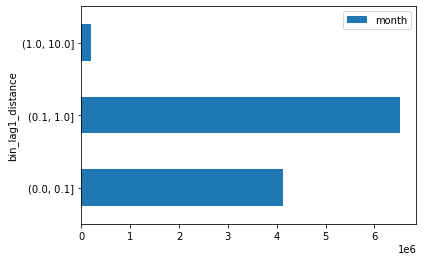

In [42]:
prep_data[['month','bin_lag1_distance']].groupby('bin_lag1_distance').agg('count').plot(kind='barh')
plt.show()

The Distance Data is Super Skewed, we can use median total distance per empty taxi in each month for measure central tendency

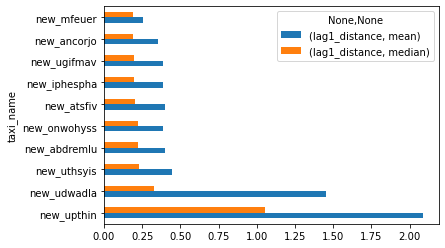

In [44]:
prep_data[['taxi_name','lag1_distance']].groupby('taxi_name').agg(['mean','median']).sort_values([('lag1_distance', 'median')],
                                                                        ascending=False).head(10).plot(kind='barh')
plt.show()

### Finding Median distance for empty taxi per month

In [46]:
empty_taxi_monthly_data = prep_data.query('occupancy==0')[['month','taxi_name',
                        'lag1_distance']].groupby(['month','taxi_name']).aggregate({'lag1_distance':["sum"]})
empty_taxi_monthly_data = empty_taxi_monthly_data.reset_index()

In [47]:
empty_taxi_monthly_data.describe()

,month,lag1_distance
,,sum
count,1044.00000,1044.000000
mean,5.50000,1210.972511
std,0.50024,1310.271366
min,5.00000,0.000000
25%,5.00000,856.368147
50%,5.50000,1092.341639
75%,6.00000,1437.382591
max,6.00000,31984.703996


Median total distance for empty taxi per month is around 1092.34 Mile

## Answers

### CO2 Yearly Reduction

In [60]:
#declare static variables
total_taxi = len(prep_data['taxi_name'].unique())
empty_rate = 0.5519
median_total_distance_empty_taxi = 1092.34
ev_conversion_rate = 0.15
icev_reduction_rate = 1-ev_conversion_rate
co2grampermiles=404

dict_table_sum = {'month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                  'median_total_distance_empty_taxi':[median_total_distance_empty_taxi]*12,
                  'empty_rate': [empty_rate]*12,
                  'total_taxi': [total_taxi]*12,
                }
table_sum = pd.DataFrame(dict_table_sum)
table_sum['remaining_icev'] = table_sum['total_taxi'].copy()

In [61]:
for i in range(1, len(table_sum)):
    table_sum.loc[i, 'remaining_icev'] = table_sum.loc[i-1, 'remaining_icev'] * icev_reduction_rate 
table_sum['remaining_icev'] = table_sum['remaining_icev'].astype(int)
table_sum['total_empty_taxi_icev'] = (table_sum['total_taxi'] * table_sum['empty_rate']).astype(int)
table_sum['total_remaining_empty_icev'] = (table_sum['remaining_icev']*table_sum['empty_rate']).astype(int)
table_sum['co2_before'] = (table_sum['total_empty_taxi_icev'] * table_sum['median_total_distance_empty_taxi'] * co2grampermiles).astype(int)
table_sum['co2_after'] = (table_sum['total_remaining_empty_icev'] * table_sum['median_total_distance_empty_taxi'] * co2grampermiles).astype(int)

In [62]:
table_sum

,month,median_total_distance_empty_taxi,empty_rate,total_taxi,remaining_icev,total_empty_taxi_icev,total_remaining_empty_icev,co2_before,co2_after
0,Jan,1092.34,0.5519,537,537,296,296,130626386,130626386
1,Feb,1092.34,0.5519,537,456,296,251,130626386,110767645
2,Mar,1092.34,0.5519,537,387,296,213,130626386,93998041
3,Apr,1092.34,0.5519,537,329,296,181,130626386,79876270
4,May,1092.34,0.5519,537,280,296,154,130626386,67961025
5,Jun,1092.34,0.5519,537,238,296,131,130626386,57811002
6,Jul,1092.34,0.5519,537,202,296,111,130626386,48984894
7,Aug,1092.34,0.5519,537,172,296,94,130626386,41482703
8,Sep,1092.34,0.5519,537,146,296,80,130626386,35304428
9,Oct,1092.34,0.5519,537,124,296,68,130626386,30008764


In [63]:
co2_reduction_rate = round(sum(table_sum['co2_after'])/sum(table_sum['co2_before']) * 100,2)
co2_reduction_rate

47.44

15% electric cars conversion each month will reduce the CO2 emission of unoccupied taxi around 47.44% compared to if there were no electric cars conversion happening at all

### Next Radius Passenger May Hail Cab Prediction

In [5]:
prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11220058 entries, 0 to 11220057
Data columns (total 55 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   lat                     float64
 1   long                    float64
 2   occupancy               int64  
 3   timestamp               int64  
 4   taxi_name               object 
 5   date                    object 
 6   month                   int64  
 7   day                     int64  
 8   hour                    int64  
 9   minute                  int64  
 10  weekday                 int64  
 11  lat_lag1                float64
 12  lat_lag2                float64
 13  long_lag1               float64
 14  long_lag2               float64
 15  ts_lag1                 int64  
 16  ts_lag2                 int64  
 17  lag2_distance           float64
 18  lag1_distance           float64
 19  lag1_min                float64
 20  lag2_min                float64
 21  weekend_flag            int32

In [6]:
prep_data.describe()

,lat,long,occupancy,timestamp,month,day,hour,minute,weekday,lat_lag1,...,lag1_min_median,lag1_min_sum,lag1_min_max,lag2_min_count,lag2_min_mean,lag2_min_median,lag2_min_sum,lag2_min_max,diff_lag1_med_min,diff_lag2_med_min
count,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.121952e+07,...,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07,1.122006e+07
mean,3.776360e+01,-1.224124e+02,4.472238e-01,1.212036e+09,5.382190e+00,1.685492e+01,1.140378e+01,2.954044e+01,3.141731e+00,3.776360e+01,...,9.976641e-01,2.021714e+07,2.018408e+07,2.276784e+04,1.935157e+03,1.994006e+00,4.043428e+07,2.018408e+07,9.668288e+02,1.933574e+03
std,5.385999e-02,3.578201e-02,4.972069e-01,5.885683e+05,4.859227e-01,1.003906e+01,7.294970e+00,1.731320e+01,2.082145e+00,5.385854e-02,...,2.930093e-02,1.917873e+03,2.380531e+03,4.684702e+03,2.405396e+03,7.939329e-02,3.836070e+03,2.390095e+03,1.396381e+05,1.974734e+05
min,3.286970e+01,-1.270814e+02,0.000000e+00,1.211018e+09,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.286970e+01,...,5.800000e-01,2.018377e+07,2.018364e+07,5.900000e+01,8.190620e+02,1.020000e+00,4.036754e+07,2.018364e+07,0.000000e+00,0.000000e+00
25%,3.775513e+01,-1.224253e+02,0.000000e+00,1.211523e+09,5.000000e+00,6.000000e+00,5.000000e+00,1.500000e+01,1.000000e+00,3.775513e+01,...,1.000000e+00,2.021725e+07,2.018364e+07,2.095000e+04,1.581764e+03,2.000000e+00,4.043449e+07,2.018364e+07,2.000000e-02,2.000000e-02
50%,3.778106e+01,-1.224111e+02,0.000000e+00,1.212043e+09,5.000000e+00,2.000000e+01,1.200000e+01,3.000000e+01,3.000000e+00,3.778107e+01,...,1.000000e+00,2.021729e+07,2.018364e+07,2.355800e+04,1.716384e+03,2.000000e+00,4.043457e+07,2.018364e+07,8.000000e-02,1.300000e-01
75%,3.779045e+01,-1.224003e+02,1.000000e+00,1.212549e+09,6.000000e+00,2.600000e+01,1.800000e+01,4.500000e+01,5.000000e+00,3.779045e+01,...,1.000000e+00,2.021732e+07,2.018380e+07,2.556300e+04,1.930053e+03,2.000000e+00,4.043464e+07,2.018381e+07,2.500000e-01,5.700000e-01
max,5.030546e+01,-1.155622e+02,1.000000e+00,1.213090e+09,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,6.000000e+00,5.030546e+01,...,1.020000e+00,2.021817e+07,2.021274e+07,4.936700e+04,6.849125e+05,3.020000e+00,4.043633e+07,2.021274e+07,2.021274e+07,2.021274e+07


In [7]:
prep_data.head()

,lat,long,occupancy,timestamp,taxi_name,date,month,day,hour,minute,...,lag1_min_median,lag1_min_sum,lag1_min_max,lag2_min_count,lag2_min_mean,lag2_min_median,lag2_min_sum,lag2_min_max,diff_lag1_med_min,diff_lag2_med_min
0,37.75153,-122.39447,0,1211033530,new_abboip,2008-05-17,5,17,14,12,...,1.0,20218083.24,20183892.17,23495,1721.053899,2.0,4.043616e+07,20183893.57,20183891.17,20183890.17
1,37.75149,-122.39447,0,1211033614,new_abboip,2008-05-17,5,17,14,13,...,1.0,20218083.24,20183892.17,23495,1721.053899,2.0,4.043616e+07,20183893.57,0.40,20183891.57
2,37.75149,-122.39447,0,1211033674,new_abboip,2008-05-17,5,17,14,14,...,1.0,20218083.24,20183892.17,23495,1721.053899,2.0,4.043616e+07,20183893.57,0.00,0.40
3,37.75149,-122.39446,0,1211033735,new_abboip,2008-05-17,5,17,14,15,...,1.0,20218083.24,20183892.17,23495,1721.053899,2.0,4.043616e+07,20183893.57,0.02,0.02
4,37.75144,-122.39449,0,1211035303,new_abboip,2008-05-17,5,17,14,41,...,1.0,20218083.24,20183892.17,23495,1721.053899,2.0,4.043616e+07,20183893.57,25.13,25.15


#### Handling Missing Values

In [8]:
prep_data.isnull().sum()

lat                          0
long                         0
occupancy                    0
timestamp                    0
taxi_name                    0
date                         0
month                        0
day                          0
hour                         0
minute                       0
weekday                      0
lat_lag1                   537
lat_lag2                  1074
long_lag1                  537
long_lag2                 1074
ts_lag1                      0
ts_lag2                      0
lag2_distance                0
lag1_distance                0
lag1_min                     0
lag2_min                     0
weekend_flag                 0
holiday_flag                 0
lat_lag1_count               0
lat_lag1_mean                0
lat_lag1_median              0
lat_lag1_min                 0
lat_lag1_max                 0
long_lag1_count              0
long_lag1_mean               0
long_lag1_median             0
long_lag1_min                0
long_lag

null values appear because we want to predict next distance with 2 previous distance (lag) information, so we will drop the null records because it will affect the difference calculation of distance & minutes

In [9]:
prep_data = prep_data.dropna()

In [10]:
prep_data.isnull().sum().sum()

0

#### Feature Selection

In [20]:
col_num = ['lat_lag1','lat_lag2','long_lag1','long_lag2','occupancy','lag1_distance','lag2_distance','lag1_min','lag2_min',
          'lat_lag1_median','long_lag1_median','lag1_distance_median','lag2_distance_median',
          'diff_lag1_med_distance','diff_lag2_med_distance','lag1_distance_per_min','lag2_distance_per_min',
          'lag1_min_median','lag2_min_median','diff_lag1_med_min','diff_lag2_med_min']
col_target = ['lag1_distance']

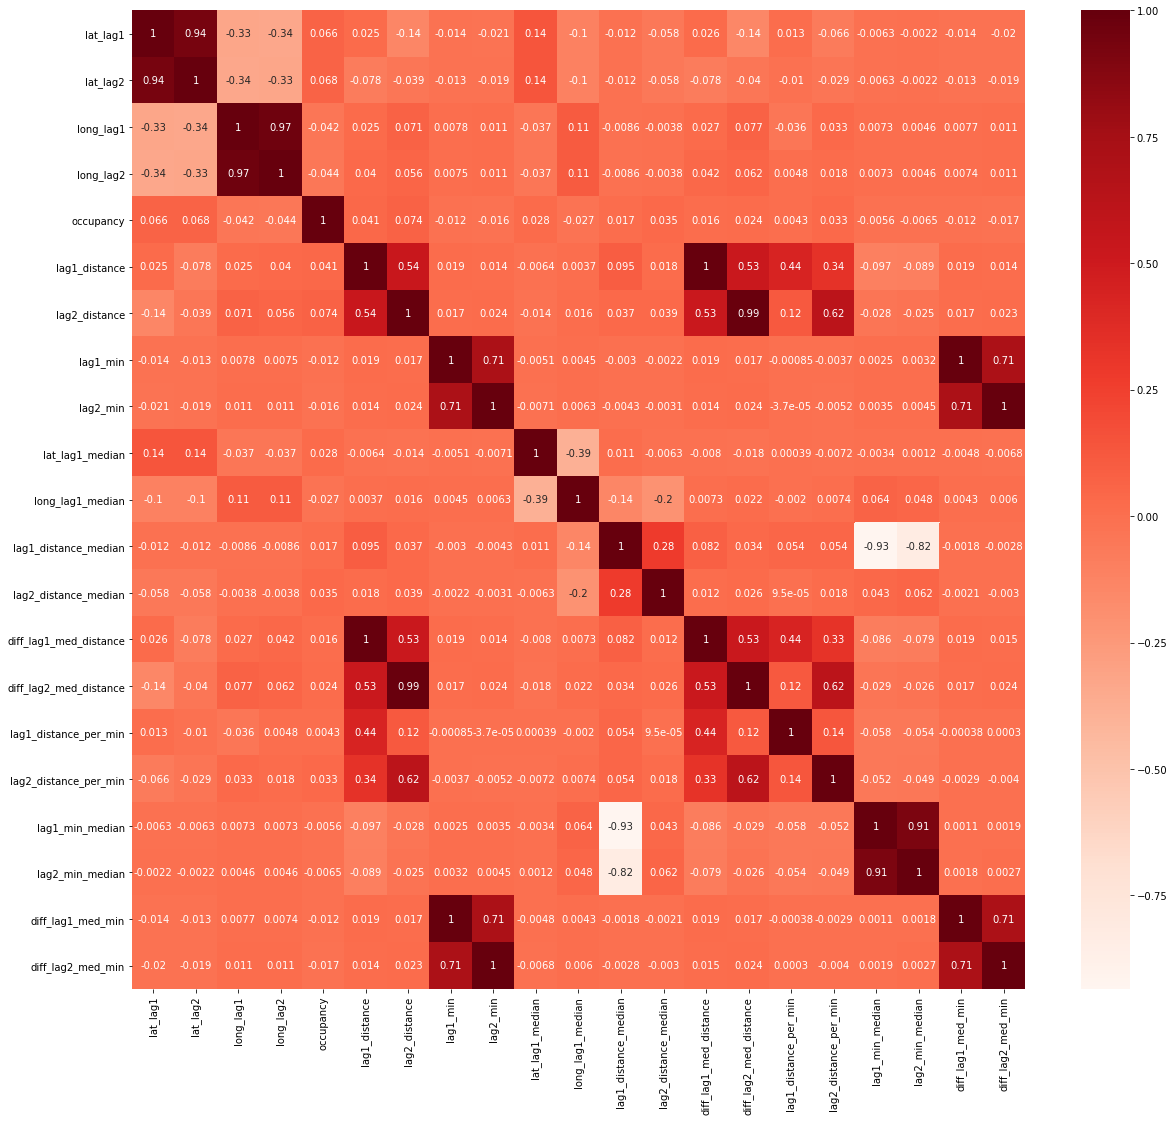

In [21]:
import seaborn as sns
plt.figure(figsize=(20,18))
cor = prep_data[col_num].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [22]:
col_pred = ['lag2_distance','weekend_flag','holiday_flag','diff_lag1_med_distance',
           'diff_lag2_med_distance','lag1_distance_per_min','lag2_distance_per_min']

#### Split Data

In [23]:
list_sample=['train','valid','test']
prep_data["flag_sample"] = np.random.choice(list_sample, size=len(prep_data), p=[0.6,0.2,0.2])

In [24]:
prep_data[['flag_sample','occupancy']].groupby('flag_sample').agg('count')

,occupancy
flag_sample,
test,2245788
train,6730948
valid,2242248


In [25]:
train_mask = prep_data['flag_sample'] == 'train'
valid_mask = prep_data['flag_sample'] == 'valid'
test_mask = prep_data['flag_sample'] == 'test'

#### Model

##### Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox

In [28]:
lr_target_col = 'log_lag1_distance'

In [29]:
# Log Transformation in Python
prep_data[lr_target_col]=np.log(prep_data['lag1_distance'])

C:\Users\Bayu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
prep_data[lr_target_col].describe()

count    1.121898e+07
mean             -inf
std               NaN
min              -inf
25%     -3.904489e+00
50%     -1.929424e+00
75%     -1.251531e+00
max      6.775889e+00
Name: log_lag1_distance, dtype: float64

In [31]:
prep_data[lr_target_col].replace(to_replace=np.inf, value= 9, inplace=True)
prep_data[lr_target_col].replace(to_replace=-np.inf, value= -9, inplace=True)
prep_data[lr_target_col].replace(to_replace=np.nan, value= -9, inplace=True)

In [33]:
col_pred_bin = []
for pred in col_pred:
    prep_data['bin_'+pred] = pd.cut(prep_data[pred],20).values.add_categories('-111')
    prep_data['bin_'+pred].fillna('-111',inplace=True)
    prep_data['bin_'+pred] = prep_data['bin_'+pred].cat.codes
    col_pred_bin.append('bin_'+pred)

In [42]:
reg_l = LinearRegression().fit(prep_data[train_mask][col_pred_bin], prep_data[train_mask][lr_target_col])

In [43]:
lr_pred_col = 'lr_pred'

In [44]:
prep_data[lr_pred_col] = reg_l.predict(prep_data[col_pred_bin])

In [45]:
prep_data[lr_pred_col] = np.exp(prep_data[lr_pred_col])

##### Light GBM

In [47]:
import lightgbm as lgb

In [48]:
col_pred

['lag2_distance',
 'weekend_flag',
 'holiday_flag',
 'diff_lag1_med_distance',
 'diff_lag2_med_distance',
 'lag1_distance_per_min',
 'lag2_distance_per_min']

In [49]:
lgb_params = {
    "num_iterations": 300,
    "learning_rate": 0.05,
    "num_leaves": 100,
    "colsample_bytree": 0.75,
    "subsample": 0.75,
    "subsample_freq": 1,
    "max_depth": 2,
    "nthreads": 3,
    "verbose": 1,
    "objective": "regression",
    "seed": 1234,
    "metrics":['mae','mse','rmse'],
}

In [53]:
lgb_model = lgb.train(lgb_params, lgb.Dataset(prep_data[col_pred][train_mask], label=prep_data[col_target][train_mask]),
                feature_name = col_pred, valid_sets=lgb.Dataset(prep_data[col_pred+col_target][valid_mask]))

C:\Users\Bayu\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 6730948, number of used features: 6
[LightGBM] [Info] Start training from score 0.255491
[1]	valid_0's l1: 0.255472	valid_0's l2: 0.065974	valid_0's rmse: 0.256854
[2]	valid_0's l1: 0.25547	valid_0's l2: 0.0676068	valid_0's rmse: 0.260013
[3]	valid_0's l1: 0.255451	valid_0's l2: 0.0702124	valid_0's rmse: 0.264976
[4]	valid_0's l1: 0.255437	valid_0's l2: 0.0738658	valid_0's rmse: 0.271783
[5]	valid_0's l1: 0.255437	valid_0's l2: 0.0785038	valid_0's rmse: 0.280185
[6]	valid_0's l1: 0.255463	valid_0's l2: 0.0836505	valid_0's rmse: 0.289224
[7]	valid_0's l1: 0.255477	valid_0's l2: 0.0881371	valid_0's rmse: 0.296879
[8]	valid_0's l1: 0.255458	valid_0's l2: 0.0940657	valid_0's

[104]	valid_0's l1: 0.255606	valid_0's l2: 0.483378	valid_0's rmse: 0.695254
[105]	valid_0's l1: 0.255615	valid_0's l2: 0.485066	valid_0's rmse: 0.696467
[106]	valid_0's l1: 0.255591	valid_0's l2: 0.485797	valid_0's rmse: 0.696991
[107]	valid_0's l1: 0.255587	valid_0's l2: 0.484447	valid_0's rmse: 0.696022
[108]	valid_0's l1: 0.255568	valid_0's l2: 0.482979	valid_0's rmse: 0.694967
[109]	valid_0's l1: 0.25557	valid_0's l2: 0.484001	valid_0's rmse: 0.695702
[110]	valid_0's l1: 0.255555	valid_0's l2: 0.484599	valid_0's rmse: 0.696131
[111]	valid_0's l1: 0.255564	valid_0's l2: 0.485814	valid_0's rmse: 0.697003
[112]	valid_0's l1: 0.255571	valid_0's l2: 0.487133	valid_0's rmse: 0.697949
[113]	valid_0's l1: 0.25557	valid_0's l2: 0.489969	valid_0's rmse: 0.699978
[114]	valid_0's l1: 0.255584	valid_0's l2: 0.491571	valid_0's rmse: 0.701121
[115]	valid_0's l1: 0.255584	valid_0's l2: 0.49248	valid_0's rmse: 0.701769
[116]	valid_0's l1: 0.255591	valid_0's l2: 0.493331	valid_0's rmse: 0.702375
[1

[212]	valid_0's l1: 0.255678	valid_0's l2: 0.535804	valid_0's rmse: 0.731986
[213]	valid_0's l1: 0.255671	valid_0's l2: 0.53519	valid_0's rmse: 0.731566
[214]	valid_0's l1: 0.255659	valid_0's l2: 0.534994	valid_0's rmse: 0.731433
[215]	valid_0's l1: 0.255664	valid_0's l2: 0.535561	valid_0's rmse: 0.731821
[216]	valid_0's l1: 0.255684	valid_0's l2: 0.537648	valid_0's rmse: 0.733245
[217]	valid_0's l1: 0.255666	valid_0's l2: 0.536173	valid_0's rmse: 0.732238
[218]	valid_0's l1: 0.255671	valid_0's l2: 0.539016	valid_0's rmse: 0.734177
[219]	valid_0's l1: 0.255669	valid_0's l2: 0.537892	valid_0's rmse: 0.733411
[220]	valid_0's l1: 0.255681	valid_0's l2: 0.542892	valid_0's rmse: 0.736812
[221]	valid_0's l1: 0.255663	valid_0's l2: 0.540319	valid_0's rmse: 0.735064
[222]	valid_0's l1: 0.255645	valid_0's l2: 0.538735	valid_0's rmse: 0.733986
[223]	valid_0's l1: 0.255642	valid_0's l2: 0.538012	valid_0's rmse: 0.733493
[224]	valid_0's l1: 0.255646	valid_0's l2: 0.540972	valid_0's rmse: 0.735508


In [54]:
lgb_pred_col = 'lgb_pred'

In [55]:
prep_data[lgb_pred_col] = lgb_model.predict(prep_data[col_pred])

#### Evaluation

In [60]:
from sklearn.metrics import mean_absolute_error as mae

dict_eval = {'sample':['train','valid','test']}
for prediction in (lr_pred_col,lgb_pred_col):
    mae_list = []
    for mask in (train_mask,valid_mask,test_mask):
        mae_ = mae(prep_data[mask][col_target], prep_data[mask][prediction])
        mae_list.append(mae_)
    dict_eval[prediction] = mae_list

In [61]:
eval_table = pd.DataFrame(dict_eval)
eval_table.columns = ['sample','LR','XGB']
eval_table

,sample,LR,XGB
0,train,0.807258,0.041910
1,valid,2.283690,0.043509
2,test,0.428048,0.042128


In [63]:
prep_data[['lag1_distance','lgb_pred']]

,lag1_distance,lgb_pred
2,0.000000,0.006121
3,0.000548,0.006121
4,0.003820,0.006121
5,0.005301,0.006121
6,0.028517,0.020675
...,...,...
11220053,0.115553,0.102845
11220054,0.335968,0.286202
11220055,0.377852,0.395509
11220056,0.249318,0.245160


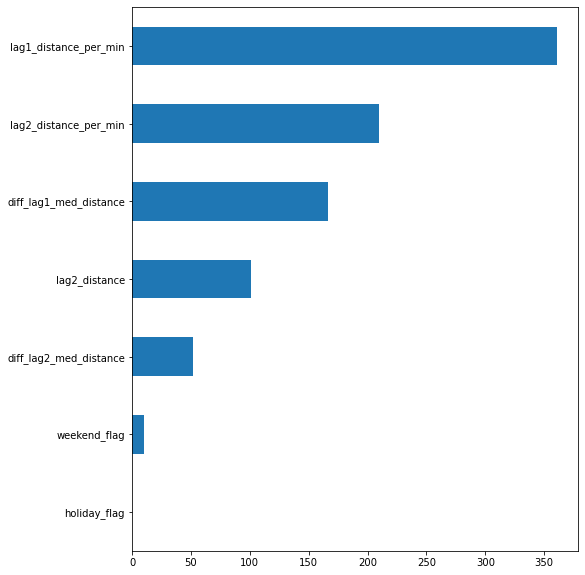

In [64]:
feature_importance = pd.Series(lgb_model.feature_importance(), index=col_pred)
feature_importance.nlargest(30).sort_values().plot(kind='barh', figsize=(8,10))

In [65]:
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 72
__builtins__ 72
_ih 648
_oh 640
_dh 64
In 648
Out 640
get_ipython 136
exit 48
quit 48
_ 48
__ 269255632
___ 411
json 72
getsizeof 72
NamespaceMagics 896
_nms 48
_Jupyter 48
np 72
_getsizeof 136
_getshapeof 136
var_dic_list 136
_i 207
_ii 88
_iii 85
_i1 172
_i2 263
pd 72
dt 72
os 72
listdir 72
jp 136
plt 72
math 72
gc 72
geodesic 1064
_i3 172
prep_data 7054403230
_i4 74
_i5 65
_i6 69
_6 3891
_i7 65
_7 2691
_i8 73
_8 8271
_i9 79
_i10 79
_10 32
_i11 102
_i12 62
_12 2156
_i13 176
sns 72
_i14 511
col_num 224
col_target 64
_i15 72
_15 28
_i16 188
_i17 188
_i18 523
_i19 188
_i20 493
_i21 188
_i22 217
col_pred 112
_i23 180
list_sample 80
_i24 123
_24 225
_i25 193
train_mask 100970872
valid_mask 100970872
test_mask 100970872
_i26 59
_i27 129
LinearRegression 1192
boxcox 136
_i28 84
lr_target_col 66
_i29 139
_i30 84
_30 883
_i31 279
_i32 323
col_pred_bin 120
pred 114
_i33 328
_i34 149
_i35 149
_i36 149
_i37 149
_i38 

In [66]:
del train_mask,valid_mask,test_mask,mask
gc.collect()

137

### Taxi Cab PoV  using RFM segmentation

#### Determine R,F,M values

In [71]:
distance_covered_total =  prep_data.groupby(by=['taxi_name'])['lag1_distance'].sum()

In [72]:
distance_covered_total

taxi_name
new_abboip      4546.102764
new_abcoij       138.853950
new_abdremlu    8720.187611
new_abgibo      6116.161529
new_abjoolaw    2161.437382
                   ...     
new_uvburki     3007.626831
new_uvigcho     6994.529964
new_uvjeahot    6102.136972
new_uvjova      3837.656270
new_uvreoipy    6287.051171
Name: lag1_distance, Length: 537, dtype: float64

In [75]:
distance_covered_wp =  prep_data.query('occupancy==0')[['taxi_name','lag1_distance']].groupby(by=['taxi_name'])['lag1_distance'].sum()

In [76]:
distance_covered_wp

taxi_name
new_abboip      1975.101484
new_abcoij        79.675631
new_abdremlu    3922.431535
new_abgibo      2584.804517
new_abjoolaw     801.259660
                   ...     
new_uvburki     1289.139884
new_uvigcho     3522.848774
new_uvjeahot    2874.103729
new_uvjova      1641.525358
new_uvreoipy    2880.980380
Name: lag1_distance, Length: 537, dtype: float64

In [77]:
minutes_covered =  prep_data.groupby(by=['taxi_name'])['lag1_min'].sum()

In [85]:
day_data = pd.DataFrame()
day_data = prep_data[['taxi_name','month','day']]
day_data = day_data.drop_duplicates()
days_covered = day_data.groupby(by=['taxi_name'])['day'].count()

In [86]:
days_covered

taxi_name
new_abboip      25
new_abcoij      13
new_abdremlu    24
new_abgibo      25
new_abjoolaw    11
                ..
new_uvburki     14
new_uvigcho     24
new_uvjeahot    24
new_uvjova      19
new_uvreoipy    24
Name: day, Length: 537, dtype: int64

In [90]:
active_min_per_day = pd.merge(minutes_covered,days_covered,on='taxi_name',how='left')
active_min_per_day['avg_active']=round(active_min_per_day['lag1_min']/active_min_per_day['day'],2)
active_min_per_day

,lag1_min,day,avg_active
taxi_name,,,
new_abboip,34189.67,25,1367.59
new_abcoij,24028.18,13,1848.32
new_abdremlu,33438.26,24,1393.26
new_abgibo,34510.04,25,1380.40
new_abjoolaw,33422.65,11,3038.42
...,...,...,...
new_uvburki,33664.88,14,2404.63
new_uvigcho,33644.79,24,1401.87
new_uvjeahot,33592.99,24,1399.71


In [123]:
rfm_df = pd.merge(distance_covered_total,active_min_per_day['avg_active'],on='taxi_name',how='left')

In [124]:
rfm_df = pd.merge(rfm_df,distance_covered_wp,on='taxi_name',how='left')

In [125]:
rfm_df.rename(columns={'lag1_distance_x': 'MileCoveredTotal', 'avg_active': 'AvgMinPerDay',
                         'lag1_distance_y': 'MileCoveredWP'}, inplace=True)

In [126]:
rfm_df

,MileCoveredTotal,AvgMinPerDay,MileCoveredWP
taxi_name,,,
new_abboip,4546.102764,1367.59,1975.101484
new_abcoij,138.853950,1848.32,79.675631
new_abdremlu,8720.187611,1393.26,3922.431535
new_abgibo,6116.161529,1380.40,2584.804517
new_abjoolaw,2161.437382,3038.42,801.259660
...,...,...,...
new_uvburki,3007.626831,2404.63,1289.139884
new_uvigcho,6994.529964,1401.87,3522.848774
new_uvjeahot,6102.136972,1399.71,2874.103729


#### Calculate RFM Score

In [127]:
quantile = rfm_df.quantile(q=[0.25,0.5,0.75])
quantile = quantile.to_dict()

In [128]:
quantile

{'MileCoveredTotal': {0.25: 4615.189363087842,
  0.5: 5441.309340736244,
  0.75: 5983.827727694726},
 'AvgMinPerDay': {0.25: 1381.13, 0.5: 1400.07, 0.75: 1402.83},
 'MileCoveredWP': {0.25: 1931.899685435575,
  0.5: 2324.0868610145358,
  0.75: 2638.8510645476636}}

In [129]:
def calc_RFMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [130]:
rfm_df['r_score'] = rfm_df['MileCoveredTotal'].apply(calc_RFMScore, args=('MileCoveredTotal',quantile,))
rfm_df['f_score'] = rfm_df['AvgMinPerDay'].apply(calc_RFMScore, args=('AvgMinPerDay',quantile,))
rfm_df['m_score'] = rfm_df['MileCoveredWP'].apply(calc_RFMScore, args=('MileCoveredWP',quantile,))

#### Create RFM Group / Clusters

In [131]:
rfm_df['RFM_group'] = rfm_df.r_score.map(str) + rfm_df.f_score.map(str) + rfm_df.m_score.map(str)

In [132]:
rfm_df.groupby(by=['RFM_group'])['RFM_group'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,RFM_group,count
7,141,58
0,111,50
42,434,43
40,424,32
14,222,28
10,212,26
28,323,25
31,333,23
17,232,22
21,242,20


#### Naming clusters using Taxi Cab company PoV

##### The Road Conqueror (Most Distance Covered by Taxi Driver)

Taxi Driver with total distance coverage is in the top %25

In [133]:
len(rfm_df[rfm_df['r_score']==4])

134

##### The Most Occupied Taxi

Taxi Driver with distance coverage with passanger is in the top %25

In [140]:
len(rfm_df[rfm_df['m_score']==4])

134

##### Swift & Vacant Taxi Driver 

Taxi Driver with total distance coverage is in the top %25 and active minutes per day is in the bottom %25 and distance coverage with passanger is in the top %25

In [137]:
len(rfm_df[rfm_df['RFM_group']=='414'])

18

##### The Bounty Hunter

Taxi Driver with total distance coverage , distance coverage with passanger and active minutes per day are in the top %25

In [138]:
len(rfm_df[rfm_df['RFM_group']=='444'])

16

##### The Inactive Taxi Driver

Taxi Driver with total distance coverage , distance coverage with passanger and active minutes per day are in the bottom %25

In [139]:
len(rfm_df[rfm_df['RFM_group']=='111'])

50